In [1]:
import os
import numpy as np
import pickle
from functools import partial
from PIL import Image
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from model import make_generator, make_discriminator
from loss import wloss, gradient_penalty_wloss
from utils import tile_images, generate_images, parsing, RandomWeightedAverage
from prepare_data import get_mnist

Using TensorFlow backend.


In [2]:
X_train = get_mnist()
generator = make_generator()
discriminator = make_discriminator()

---loading MNIST---
---loaded----


### Build generator

In [3]:
for layer in discriminator.layers:
    layer.trainable = False
    discriminator.trainable = False
generator_input = Input(shape=(100,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input],
                        outputs=[discriminator_layers_for_generator])
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                        loss=wloss)

In [4]:
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         7276993   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 5336961   
Total params: 12,613,954
Trainable params: 7,263,937
Non-trainable params: 5,350,017
_________________________________________________________________


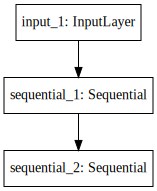

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(generator_model).create(prog='dot', format='svg'))

In [12]:
BATCH_SIZE = 64
GRADIENT_PENALTY_WEIGHT = 10

for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(100,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage(BATCH_SIZE)([real_samples,
                                                      generated_samples_for_discriminator])

averaged_samples_out = discriminator(averaged_samples)

partial_gp_loss = partial(gradient_penalty_wloss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
# Functions need names or Keras will throw an error
partial_gp_loss.__name__ = 'gradient_penalty'


discriminator_model = Model(inputs=[real_samples,
                                    generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])

discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                            loss=[wloss,
                                  wloss,
                                  partial_gp_loss])

In [13]:
discriminator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 28, 28, 1)    7276993     input_3[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_1 (Rand (None, 28, 28, 1)    0           input_2[0][0]                    
                                                                 sequential_1[2][0]               
__________

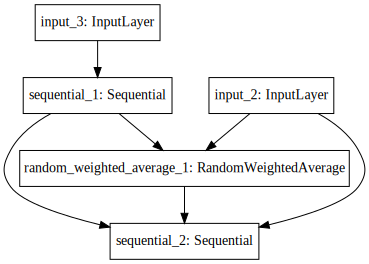

In [14]:
SVG(model_to_dot(discriminator_model).create(prog='dot', format='svg'))